In [1]:
import re
from Bio import SeqIO
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statistics

In [29]:
seq_ = 0
seq_string = ""
human_genome = SeqIO.parse("files/GCA_000001405.28_GRCh38.p13_genomic.fna", "fasta")
for chromosome in human_genome:
    if chromosome.name == "CM000664.2":
        seq_string = str(chromosome.seq).lower()
        seq_ = seq_string.encode('utf8')
        break

In [30]:
# Counting ns at the beginning and end of the string
print("number of ns in first 10000 bases: ",seq_string[:10000].count('n'))
print("number of ns in last 10000 bases: ",seq_string[-10000:].count('n'))

number of ns in first 10000 bases:  10000
number of ns in last 10000 bases:  10000


In [31]:
seq_string = seq_string[9999:-9999] #first and last 10000 bps are n's but will leave one n at the beginning and one n at the end.
seq_ = seq_[9999:-9999]

In [32]:
from hashlib import sha256
p = 2_549_536_629_329
bits_48 = 2 ** 48 - 1
scale = 0x07ffffffff

def getshavalues(subseq):
    return int(sha256(subseq).hexdigest(), 16) % bits_48
def hash_fn(sha_value,a):
    return ((sha_value * a) % p) & scale

In [33]:
# One pass quicker method to achieve the splits
# Using a list here instead of np array since np array append creates a copy of the list while list append adds to the original list. Will convert the final list of sha values to an np array.
def getNmers(seq_,interval = 15):
    seqb_sha_values = []
    counter_ = 0
    for i in range(len(seq_) - interval + 1):
        nmerb = seq_[i:i+interval]
        counter_+=1
        #print(nmer)
        if((nmerb.count(b"n")>2)):
            # print(nmer)
            # print(nmerb)
            pass
        else:
            nmerb_sha = getshavalues(nmerb)
            seqb_sha_values.append(nmerb_sha)
    return seqb_sha_values,counter_

lst_finalb,sequence_count = getNmers(seq_)

In [34]:
print("Total nmers with more than 2 ns included:",sequence_count)
print("Total 15mers with duplicates but without nmers with >2ns :",len(lst_finalb))

Total nmers with more than 2 ns included: 242173517
Total 15mers with duplicates but without nmers with >2ns : 240548029


In [35]:
## Convert lst_finalb to np array
lst_finalb = np.array(lst_finalb,int)

## Run tests on smaller pieces of data
## Ran the test 100 times and take mean of values generated in the tests. I used the following 2 methods to test:
#### For the test I thought I should randomly pull 100 sha values from lst_finalb, compute for each sha value, the 100 hashes, and for each hash function we store the minimum most value, to estimate unique elements we take the average of these hash values, subtract one from inverse of average and see how deviated that value is from 100.

#### The other test is to take calculate estimate based on each hash value, and take median of these values.

* method 1: 1/avg(hash_values) - 1
* method 2: median(1/hash_value - 1 for all hash_values)


In [141]:
deviations_avg_method = []
deviations_estimates_method = []
for i in tqdm(range(100)):
    sample_sha_vals = np.random.choice(lst_finalb,100)
    min_hashes = []
    for i in range(1,101):
        min_ = np.inf
        for j in sample_sha_vals:
            hshval = hash_fn(j,i)
            hshval/=scale
            if(hshval<min_):
                #print(hshval," i ",i)
                min_ = hshval
        min_hashes.append(min_)
    min_hashes = sorted(min_hashes)
    estimates_ = [(1/min_hash) -1 for min_hash in min_hashes]
    median_estimate = statistics.median(estimates_)
    deviations_estimates_method.append(median_estimate)
    mean_val = len(min_hashes)/sum(min_hashes) - 1
    deviations_avg_method.append(mean_val)
print("Thus estimate based on inverse of average hash value is:", statistics.mean(deviations_avg_method))
print("Thus estimate based on median of estimate of each individual hash value is:", statistics.mean(deviations_estimates_method))

  0%|          | 0/100 [00:00<?, ?it/s]

Thus estimate based on inverse of average hash value is: 101.83709212553349
Thus estimate based on median of estimate of each individual hash value is: 150.6541031693754


In [36]:
min_hashes = []
for i in tqdm(range(1,101)):
    min_ = np.inf
    for j in lst_finalb:
        hshval = hash_fn(j,i)
        hshval/=scale
        if(hshval<min_):
            #print(hshval," i ",i)
            min_ = hshval
    min_hashes.append(min_)



  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
import csv
file = open('hashes.csv', 'w', newline ='')

with file:    
    write = csv.writer(file)
    write.writerows(map(lambda x: [x], min_hashes))

* min(hxi) = 1/m+1 => m = 1/min(hxi) - 1

In [81]:
print("Upper bound of estimate",1/min(min_hashes) - 1)
print("lower bound of estimate",1/max(min_hashes) - 1)

Upper bound of estimate 11453246121.333334
lower bound of estimate 37633885.491785325


In [54]:
## True number of unique elements
len(np.unique(lst_finalb))

145002727

In [57]:
## Sorting hashvalue list, will maintain original order in min_hashes_unsorted
min_hashes = sorted(min_hashes)

In [77]:
min_hashes_unsorted = list(np.genfromtxt('hashes.csv',delimiter=','))
min_hashes_unsorted

[1.5133991837941983e-08,
 5.15137799099179e-09,
 8.149072528122606e-10,
 1.030275598198358e-08,
 1.862645149285167e-09,
 9.255018085510674e-09,
 1.7666025087751507e-08,
 1.8335413188275864e-09,
 7.275957614395184e-10,
 1.2136297300811167e-08,
 2.6571797207771212e-08,
 1.2922100723165847e-08,
 8.731149137274221e-09,
 1.3387762010487139e-09,
 2.2700987756912975e-09,
 3.667082637655173e-09,
 2.648448571639847e-08,
 3.6088749767400113e-09,
 2.415617927979201e-09,
 8.440110832698414e-10,
 2.7357600630125892e-09,
 2.0343577489848935e-08,
 6.606569513870827e-09,
 3.8126017899430765e-09,
 4.947651177788725e-09,
 2.3865140975216204e-09,
 2.561137080267105e-09,
 3.5797711462824306e-09,
 6.693881005243569e-09,
 2.852175384842912e-09,
 2.5989720598619598e-08,
 7.334165275310346e-09,
 1.8306309357818283e-08,
 6.72298483570115e-09,
 7.770722732174057e-09,
 6.8976078184466346e-09,
 8.149072528122606e-10,
 1.702574081768473e-08,
 2.4738255888943626e-09,
 1.6880221665396827e-09,
 1.891748979742748e-09,

In [79]:
# average of all values
len(min_hashes)/sum(min_hashes) - 1

133799603.23286605

(100000000.0, 1000000000.0)

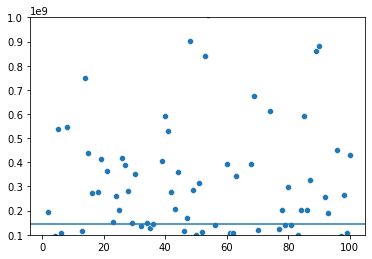

In [114]:
estimates_unsorted = [1/hash_val - 1 for hash_val in min_hashes_unsorted]
scatterplt = sns.scatterplot(x = list(range(1,101)),y = estimates_unsorted)
scatterplt.axhline(145000000)
plt.ylim([100000000,1000000000])

(10000000.0, 1000000000.0)

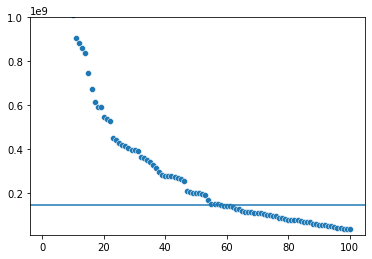

In [112]:
estimates_sorted = [1/hash_val - 1 for hash_val in min_hashes]
scatterplot_ = sns.scatterplot(x = list(range(1,101)),y = estimates_sorted)
scatterplot_.axhline(145000000)
plt.ylim([10000000,1000000000])

## Taking medians of 1,2,...n values and plotting

#### Plotting for unsorted values 

(10000000.0, 1000000000.0)

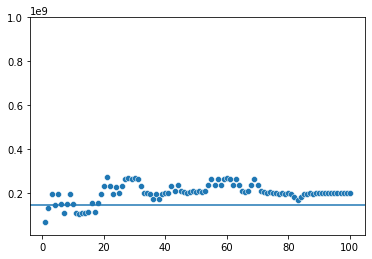

In [142]:
medians = [statistics.median(estimates_unsorted[0:i]) for i in range(1,101)]
scatterplot_ = sns.scatterplot(x = list(range(1,101)),y = medians)
scatterplot_.axhline(145000000)
#145000000 is estimated number of unique elements
plt.ylim([10000000,1000000000])

#### Plotting for sorted values

(10000000.0, 1000000000.0)

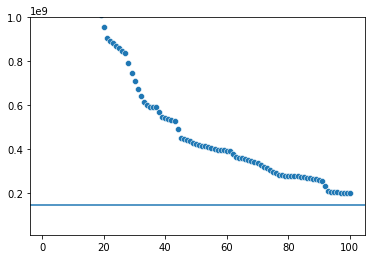

In [127]:
medians = [statistics.median(estimates_sorted[0:i]) for i in range(1,101)]
scatterplot_ = sns.scatterplot(x = list(range(1,101)),y = medians)
scatterplot_.axhline(145000000)
#145000000 is estimated number of unique elements
plt.ylim([10000000,1000000000])

In [16]:
# a_ = getshavalues(seq_[0:3])

fn_ = get_ath_hash(2)

val_ = fn_(lst_finalb[4])
val_/=scale
val_

0.9969014167726535

0.7273539886439496

In [ ]:
# This will split input string at intervals of 15, incase less than 15 the smaller sequences will be added as well, will check for length of string while checking for double n.
# def get15mers(seq_,pos,interval = 15):
#     sequence_ = seq_[pos:]
#     query_regex = ".{1,"+str(interval)+"}"
#     lst_seq = re.findall(query_regex,sequence_)  ### credit to https://stackoverflow.com/questions/9475241/split-string-every-nth-character
#     return lst_seq

# lst_sample = get15mers(seq_string,0)

# arr_seq = []
# for i in tqdm(range(0,15)):
#     lst_ = get15mers(seq_string,i)
#     arr_seq.extend(lst_)

# lst_final = []
# for i in arr_seq:
#     if((len(i)<15) or (i.count("n")>2)):
#         #print(i)
#         pass
#     else:
#         #print(i)
#         lst_final.append(i)


